### This Notebook Evaluates Replicate Out Cross-Validation to Better Measure how the model generalises

Replicate Out Cross-Validation prevents spectra from the same Surface appearing within both the training and test folds.

This gives a better indication of the model's ability to generalise, as it stops leakage between samples from the same fold.

Import Libraries

In [11]:
import pandas as pd
import seaborn as sns
import numpy as np
from scipy.signal import savgol_filter
from scipy import sparse
from scipy.sparse.linalg import spsolve
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold, KFold
from sklearn.model_selection import LeavePGroupsOut

Read the spectral data

In [12]:
df = pd.read_csv("../../data/exosomes.raw_spectrum_1.csv")
df = pd.read_csv("../../data/current_clean_spectrum.csv")

Filter the effective range from 380/400 to 1800 cm-1

In [13]:
#df = df[(df['WaveNumber'] >= 320) & (df['WaveNumber'] <= 1800)]
#df = df[(df['WaveNumber'] >= 380) & (df['WaveNumber'] <= 1800)]
df = df[(df['WaveNumber'] >= 400) & (df['WaveNumber'] <= 1800)]

df

,SpecID,Seq,WaveNumber,SurID,Status,Absorbance
0,201210-1-00,293,400.22778,201210-1,Normal,41.863303
1,201210-1-00,294,400.91116,201210-1,Normal,41.803843
2,201210-1-00,295,401.59454,201210-1,Normal,41.741884
3,201210-1-00,296,402.27789,201210-1,Normal,41.677722
4,201210-1-00,297,402.96127,201210-1,Normal,41.611654
...,...,...,...,...,...,...
6239200,210526-3-09,2337,1797.03870,210526-3,Hyperglycemia,12.378163
6239201,210526-3-09,2338,1797.72200,210526-3,Hyperglycemia,13.269937
6239202,210526-3-09,2339,1798.40550,210526-3,Hyperglycemia,14.199285
6239203,210526-3-09,2340,1799.08890,210526-3,Hyperglycemia,15.166531


In [14]:
#df.to_csv("../../data/exosomes.raw_spectrum_400-1800.csv", index=False)

In [15]:
df

,SpecID,Seq,WaveNumber,SurID,Status,Absorbance
0,201210-1-00,293,400.22778,201210-1,Normal,41.863303
1,201210-1-00,294,400.91116,201210-1,Normal,41.803843
2,201210-1-00,295,401.59454,201210-1,Normal,41.741884
3,201210-1-00,296,402.27789,201210-1,Normal,41.677722
4,201210-1-00,297,402.96127,201210-1,Normal,41.611654
...,...,...,...,...,...,...
6239200,210526-3-09,2337,1797.03870,210526-3,Hyperglycemia,12.378163
6239201,210526-3-09,2338,1797.72200,210526-3,Hyperglycemia,13.269937
6239202,210526-3-09,2339,1798.40550,210526-3,Hyperglycemia,14.199285
6239203,210526-3-09,2340,1799.08890,210526-3,Hyperglycemia,15.166531


In [16]:
df['SpecID'].unique()

array(['201210-1-00', '201210-1-01', '201210-1-02', ..., '210526-3-07',
       '210526-3-08', '210526-3-09'], dtype=object)

In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6239205 entries, 0 to 6239204
Data columns (total 6 columns):
 #   Column      Dtype  
---  ------      -----  
 0   SpecID      object 
 1   Seq         int64  
 2   WaveNumber  float64
 3   SurID       object 
 4   Status      object 
 5   Absorbance  float64
dtypes: float64(2), int64(1), object(3)
memory usage: 285.6+ MB


#### Train an Extra Trees Classifier on the full spectrum.

In [18]:
def prepare_wavelength_df(df, absorbance_col, status_col='Status'):

    # Pivot the DataFrame to get wavelengths as columns and absorbance values
    wavelength_df = df.pivot(index='SpecID', columns='WaveNumber', values=absorbance_col).reset_index()
    wavelength_df.columns.name = None

    # Merge with the statuses based on SpecID
    # Include the SurID to perform Replicate Out CV
    statuses_and_surface = df[['SpecID', 'SurID', status_col]].drop_duplicates()
    wavelength_df = pd.merge(wavelength_df, statuses_and_surface, on='SpecID')

    # Set SpecID as the index
    wavelength_df = wavelength_df.set_index('SpecID')

    return wavelength_df

In [19]:
wavelength_df = prepare_wavelength_df(df, 'Absorbance')

In [20]:
wavelength_df.head()

,400.22778,400.91116,401.59454,402.27789,402.96127,403.64465,404.32803,405.01138,405.69476,406.37814,...,1794.9886,1795.672,1796.3553,1797.0387,1797.722,1798.4055,1799.0889,1799.7722,SurID,Status
SpecID,,,,,,,,,,,,,,,,,,,,,
201210-1-00,41.863303,41.803843,41.741884,41.677722,41.611654,41.543974,41.474980,41.404968,41.334234,41.263073,...,6.280946,5.549559,4.745724,3.866578,2.909255,1.870891,0.748623,-0.460415,201210-1,Normal
201210-1-01,46.314608,47.323684,48.299209,49.241395,50.150457,51.026608,51.870063,52.681035,53.459738,54.206386,...,6.769011,7.280928,7.861246,8.512936,9.238972,10.042323,10.925962,11.892860,201210-1,Normal
201210-1-02,118.159018,114.686240,111.563911,108.777452,106.312282,104.153823,102.287493,100.698715,99.372907,98.295491,...,-4.633601,-4.557349,-4.439365,-4.278894,-4.075180,-3.827470,-3.535010,-3.197043,201210-1,Normal
201210-1-03,175.466997,174.846086,174.188020,173.498226,172.782129,172.045155,171.292728,170.530275,169.763222,168.996993,...,-10.801936,-10.349539,-9.864191,-9.347124,-8.799567,-8.222752,-7.617909,-6.986269,201210-1,Normal
201210-1-04,111.814973,106.629998,101.867380,97.512673,93.551430,89.969205,86.751551,83.884023,81.352173,79.141556,...,-11.689508,-11.752441,-11.789205,-11.799583,-11.783357,-11.740310,-11.670224,-11.572882,201210-1,Normal


>**Count the Surface IDs and the number of associated samples**

In [21]:
# Count unique combinations
unique_combos_count = wavelength_df.groupby(['Status'])['SurID'].count().reset_index(name='Counts')
unique_combos_count

,Status,Counts
0,Hyperglycemia,915
1,Hypoglycemia,1065
2,Normal,1065


>#### **Train an Extra Trees Classifier on the Raw Spectrum and evaluate it with replicate out cross-validation.**

Leaves out each SurIDs out to evaluate the models ability to generalise.

In [24]:
def evaluate_extra_trees(df):
    # Set the Surfaces as groups
    groups = df['SurID']
    X = df.drop(['Status', 'SurID'], axis=1)
    y = df['Status']

    lpgo = LeavePGroupsOut(n_groups=1)  # Leave n groups out for each iteration
    et = ExtraTreesClassifier(random_state=1234)

    group_accuracies = {}  # To store accuracies for each group
    for train_index, test_index in lpgo.split(X, y, groups):
        group_id = groups.iloc[test_index].unique()[0]  # Assuming each test set only has one group
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        
        # Train the Extra Trees classifier
        et.fit(X_train, y_train)
        predictions = et.predict(X_test)
        
        # Evaluate the model
        score = accuracy_score(y_test, predictions)
        group_accuracies[group_id] = score  # Store accuracy for the group

    # Print accuracies for each group
    for group_id, accuracy in group_accuracies.items():
        print(f'Group {group_id} Accuracy: {accuracy:.4f}')

    # Displaying overall results
    mean_accuracy = np.mean(list(group_accuracies.values()))
    std_deviation = np.std(list(group_accuracies.values()))
    print(f'\n{et.__class__.__name__} Leave-One-Group-Out Cross-Validation Accuracy: {mean_accuracy:.4f} +/- {std_deviation:.4f}')

    return group_accuracies

In [25]:
group_predictions = evaluate_extra_trees(wavelength_df)

Group 201210-1 Accuracy: 0.7143
Group 201210-2 Accuracy: 0.0200
Group 210114-1 Accuracy: 0.8400
Group 210114-2 Accuracy: 0.6400
Group 210120-1 Accuracy: 0.4200
Group 210120-2 Accuracy: 0.3000
Group 210121-1 Accuracy: 0.7200
Group 210121-2 Accuracy: 0.4600
Group 210211-1 Accuracy: 0.4600
Group 210211-2 Accuracy: 0.5800
Group 210217-1 Accuracy: 0.5600
Group 210217-2 Accuracy: 0.3800
Group 210218-1 Accuracy: 0.2600
Group 210224-1 Accuracy: 1.0000
Group 210225-1 Accuracy: 0.9800
Group 210225-2 Accuracy: 0.8000
Group 210303-1 Accuracy: 0.9400
Group 210303-2 Accuracy: 0.9200
Group 210304-1 Accuracy: 0.0000
Group 210304-2 Accuracy: 0.0200
Group 210310-1 Accuracy: 0.0000
Group 210310-2 Accuracy: 0.6800
Group 210311-1 Accuracy: 0.3400
Group 210311-2 Accuracy: 0.7000
Group 210315-1 Accuracy: 0.6000
Group 210315-2 Accuracy: 0.6800
Group 210318-1 Accuracy: 0.4800
Group 210318-2 Accuracy: 0.2800
Group 210324-1 Accuracy: 0.3600
Group 210324-2 Accuracy: 0.3400
Group 210325-1 Accuracy: 0.7400
Group 21

In [34]:
group_accuracies_df = pd.DataFrame(list(group_predictions.items()), columns=['SurID', 'Accuracy']).sort_values(by='Accuracy', ascending=False)
group_accuracies_df

,SurID,Accuracy
43,210421-1,1.00
39,210415-1,1.00
61,210526-2,1.00
13,210224-1,1.00
45,210428-2,1.00
...,...,...
19,210304-2,0.02
1,201210-2,0.02
18,210304-1,0.00
20,210310-1,0.00


Average predictive accuracy by surface status.

In [44]:
statuses = df.groupby('SurID')['Status'].first()
accuracy_and_statuses = group_accuracies_df.merge(statuses, on='SurID')
accuracy_and_statuses

,SurID,Accuracy,Status
0,210421-1,1.00,Normal
1,210415-1,1.00,Hypoglycemia
2,210526-2,1.00,Hyperglycemia
3,210224-1,1.00,Hypoglycemia
4,210428-2,1.00,Normal
...,...,...,...
58,210304-2,0.02,Hypoglycemia
59,201210-2,0.02,Normal
60,210304-1,0.00,Hypoglycemia
61,210310-1,0.00,Normal


In [45]:
accuracy_and_statuses.groupby('Status')['Accuracy'].mean()

Status
Hyperglycemia    0.581053
Hypoglycemia     0.576364
Normal           0.613074
Name: Accuracy, dtype: float64

In [47]:
pd.set_option('display.max_rows', None)
display(accuracy_and_statuses)
pd.set_option('display.max_rows', 10)

,SurID,Accuracy,Status
0,210421-1,1.000000,Normal
1,210415-1,1.000000,Hypoglycemia
2,210526-2,1.000000,Hyperglycemia
3,210224-1,1.000000,Hypoglycemia
4,210428-2,1.000000,Normal
5,210415-2,0.980000,Hypoglycemia
6,210519-1,0.980000,Hyperglycemia
7,210225-1,0.980000,Hypoglycemia
8,210428-3,0.960000,Normal
9,210325-2,0.960000,Normal


In [50]:
surface = df[df['SurID'] == "210524-1"]
surface

,SpecID,Seq,WaveNumber,SurID,Status,Absorbance
5972835,210524-1-35,293,400.22778,210524-1,Hypoglycemia,52.257148
5972836,210524-1-35,294,400.91116,210524-1,Hypoglycemia,38.777200
5972837,210524-1-35,295,401.59454,210524-1,Hypoglycemia,27.042924
5972838,210524-1-35,296,402.27789,210524-1,Hypoglycemia,16.978006
5972839,210524-1-35,297,402.96127,210524-1,Hypoglycemia,8.506130
...,...,...,...,...,...,...
6003565,210524-1-49,2337,1797.03870,210524-1,Hypoglycemia,-1.460053
6003566,210524-1-49,2338,1797.72200,210524-1,Hypoglycemia,-1.564072
6003567,210524-1-49,2339,1798.40550,210524-1,Hypoglycemia,-1.659977
6003568,210524-1-49,2340,1799.08890,210524-1,Hypoglycemia,-1.747548


In [51]:
import seaborn as sns

<Axes: xlabel='WaveNumber', ylabel='Absorbance'>

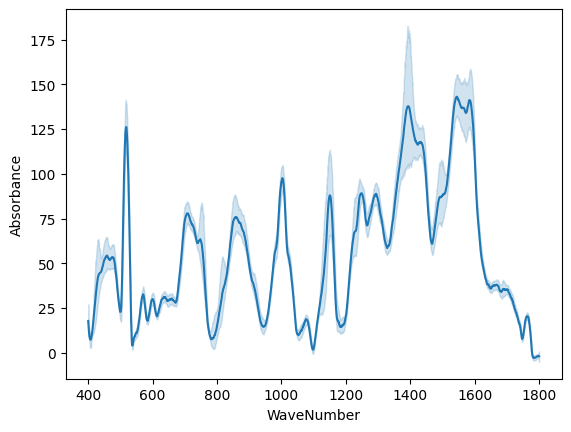

In [52]:
sns.lineplot(data=surface, x='WaveNumber', y="Absorbance", hue='SpecID')